<a href="https://colab.research.google.com/github/acf62/dcgan-colab/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
import torch.nn as nn


# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
nfg = 64

# Size of feature maps in discriminator
nfd = 64


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, nfg * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nfg * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(nfg * 4, nfg * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(nfg * 2, nfg * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg * 1),
            nn.ReLU(True),

            nn.ConvTranspose2d(nfg * 1, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, nfd, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nfd, nfd * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nfd * 2, nfd * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nfd * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


In [0]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


# Number of training epochs
num_epochs = 2

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0



def initialize_weights(layer):
    classname = layer.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(layer.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(layer.weight.data, 1.0, 0.02)
        nn.init.constant_(layer.bias.data, 0)


G = Generator(ngpu=ngpu).to(device)
D = Discriminator(ngpu=ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, list(range(ngpu)))

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    D = nn.DataParallel(D, list(range(ngpu)))


G.apply(initialize_weights)
D.apply(initialize_weights)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))


# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)


def train(data_loader):
    img_list = []
    iters = 0

    for epoch in range(num_epochs):
        for data in data_loader:
            D.zero_grad()

            batch = data[0].to(device)
            output = D(batch).view(-1)
            batch_size = batch.size(0)
            labels = torch.full((batch_size, ), real_label, device=device)
            err_d_real = criterion(output, labels)
            err_d_real.backward()

            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = G(noise)
            output = D(fake.detach()).view(-1)
            labels.fill_(fake_label)
            err_d_fake = criterion(output, labels)
            err_d_fake.backward()
            err_d = err_d_real + err_d_fake

            optimizerD.step()

            G.zero_grad()
            labels.fill_(real_label)
            output = D(fake).view(-1)
            err_g = criterion(output, labels)
            err_g.backward()

            optimizerG.step()

            if iters % 38 == 0:
                print(str(iters) + " out of " + str(len(data_loader)))
                with torch.no_grad():
                    fake = G(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            iters += 1
            # print(iters)
    
    return img_list

In [0]:
import torch.utils.data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np

# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for data_loader
workers = 0

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 32


# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dsets.MNIST(root='./data', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ]))


# Create the data_loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

img_list = train(data_loader)


0 out of 469
38 out of 469
76 out of 469
114 out of 469
152 out of 469
190 out of 469
228 out of 469
266 out of 469
304 out of 469
342 out of 469
380 out of 469
418 out of 469
456 out of 469
494 out of 469
532 out of 469
570 out of 469
608 out of 469
646 out of 469
684 out of 469
722 out of 469
760 out of 469
798 out of 469
836 out of 469
874 out of 469
912 out of 469


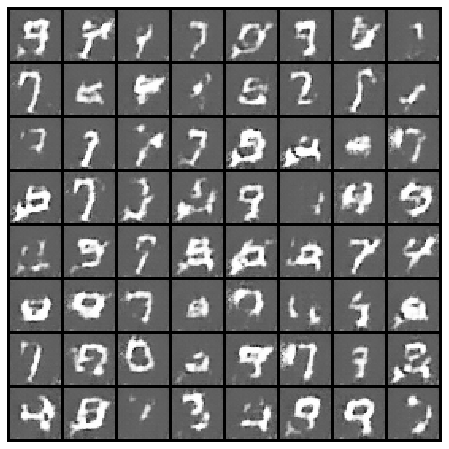

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i ,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())